In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import json
from datetime import datetime
import sys
import pandas as pd
import json
import logging
import time
import plot_utils
from importlib import reload
reload(plot_utils)

logger = logging.getLogger(__name__)
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("debug.log"),
        logging.StreamHandler(sys.stdout)
    ]
)

output_dir="."
log_file =f"{output_dir}/gateway-plugins.log.csv"

df, json_columns = plot_utils.parse_log_file(log_file)
if len(df) == 0:
    logger.error("No data found in the log file.")
df = plot_utils.parse_json_columns(df, json_columns)
df = plot_utils.normalize_time(df)
df.to_csv(f"{output_dir}/parsed-gateway-plugins.log.csv", index=False)
print()
print("podMetricsLastSecond[10].keys()")
print(df["podMetricsLastSecond"][10]['10.0.0.4'].keys())
print()
print("df.columns")
print(df.columns)
df = plot_utils.analyze_llm_inference_logs(df)
df = plot_utils.analyze_pod_metrics_last_second(df)

plot_utils.create_simple_rps_plots(df)
plot_utils.create_pod_metrics_correlation_plots(df)

NameError: name 'cutoff_time' is not defined

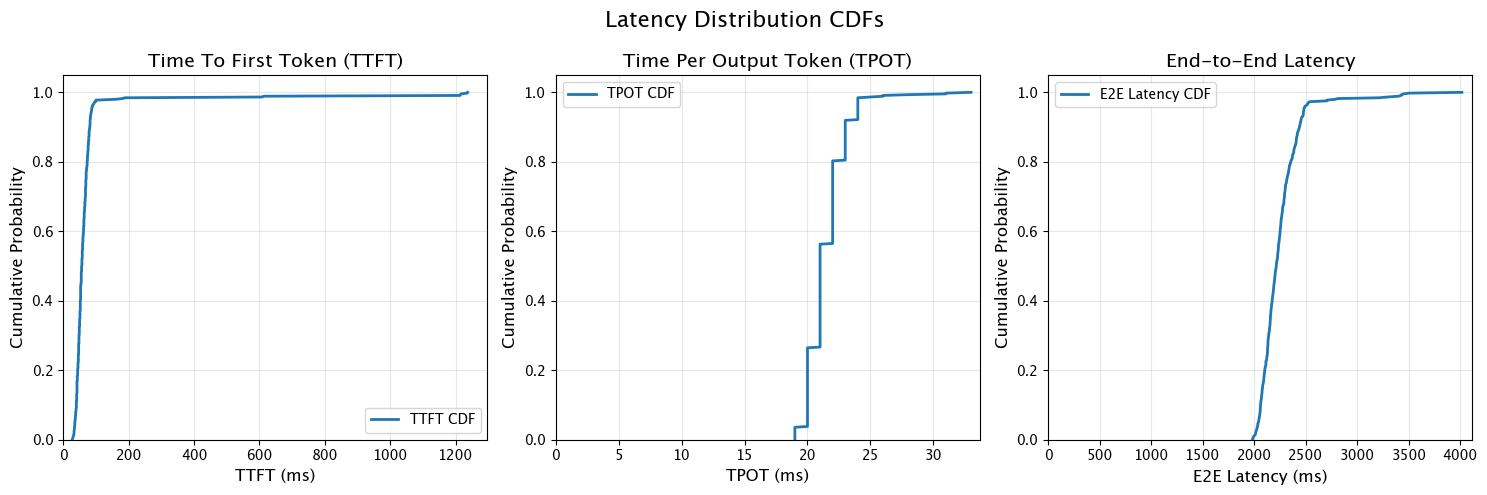

In [116]:
plot_utils.create_cdf_plots(df)

In [66]:
# plot_utils.create_e2e_latency_correlation_plots(df)

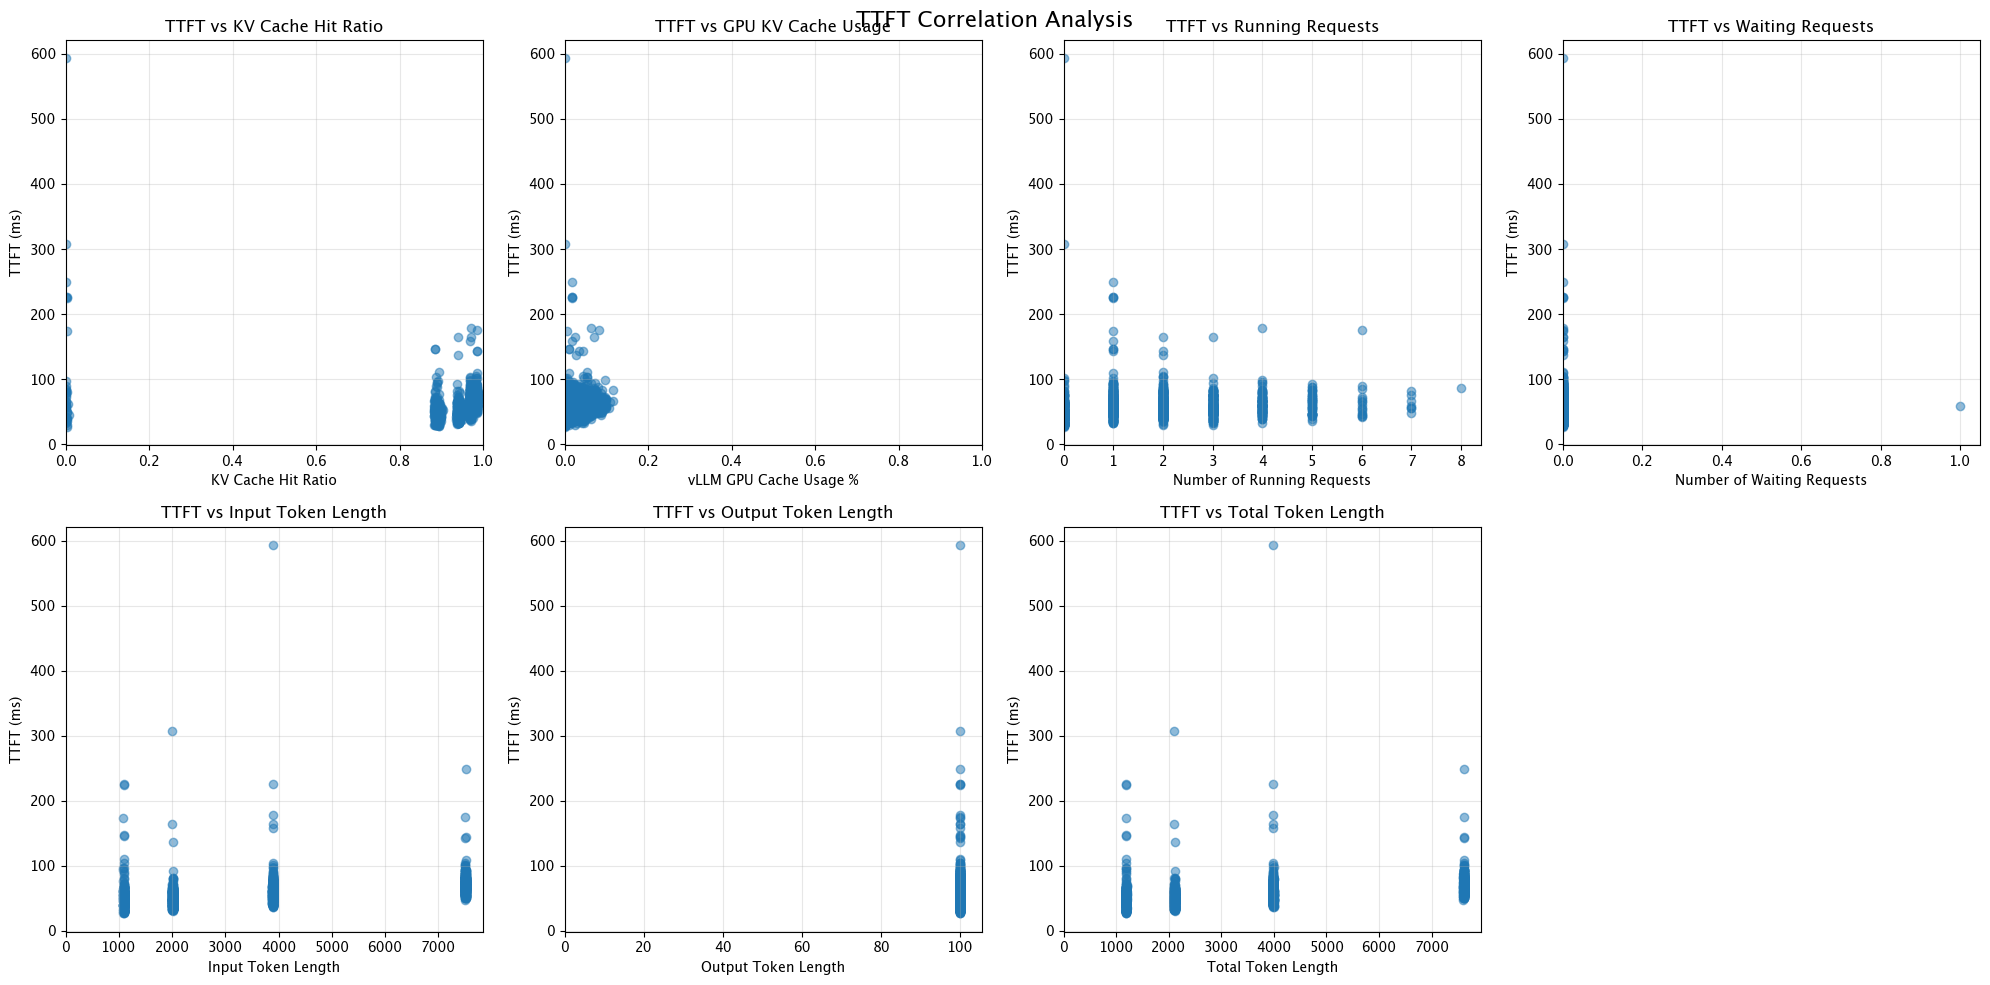

In [114]:
plot_utils.create_ttft_correlation_plots(df)

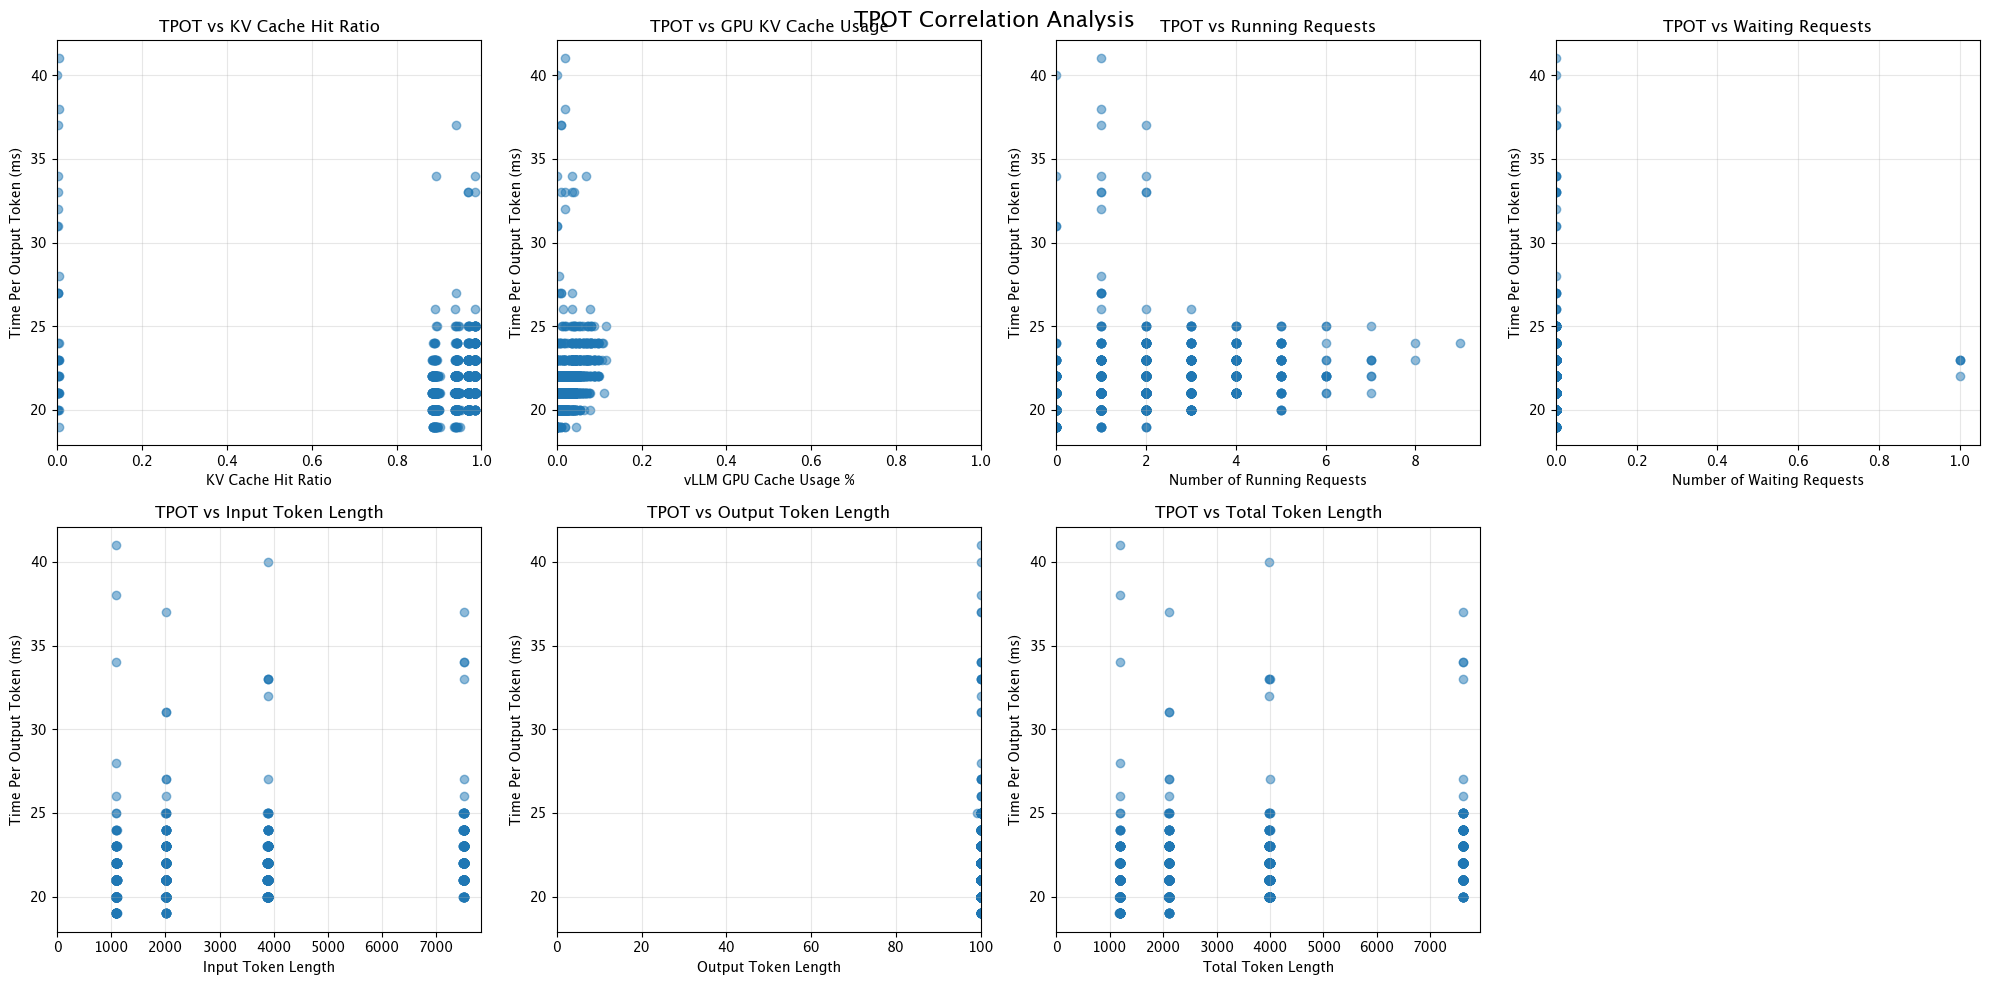

In [103]:
plot_utils.create_tpot_correlation_plots(df)

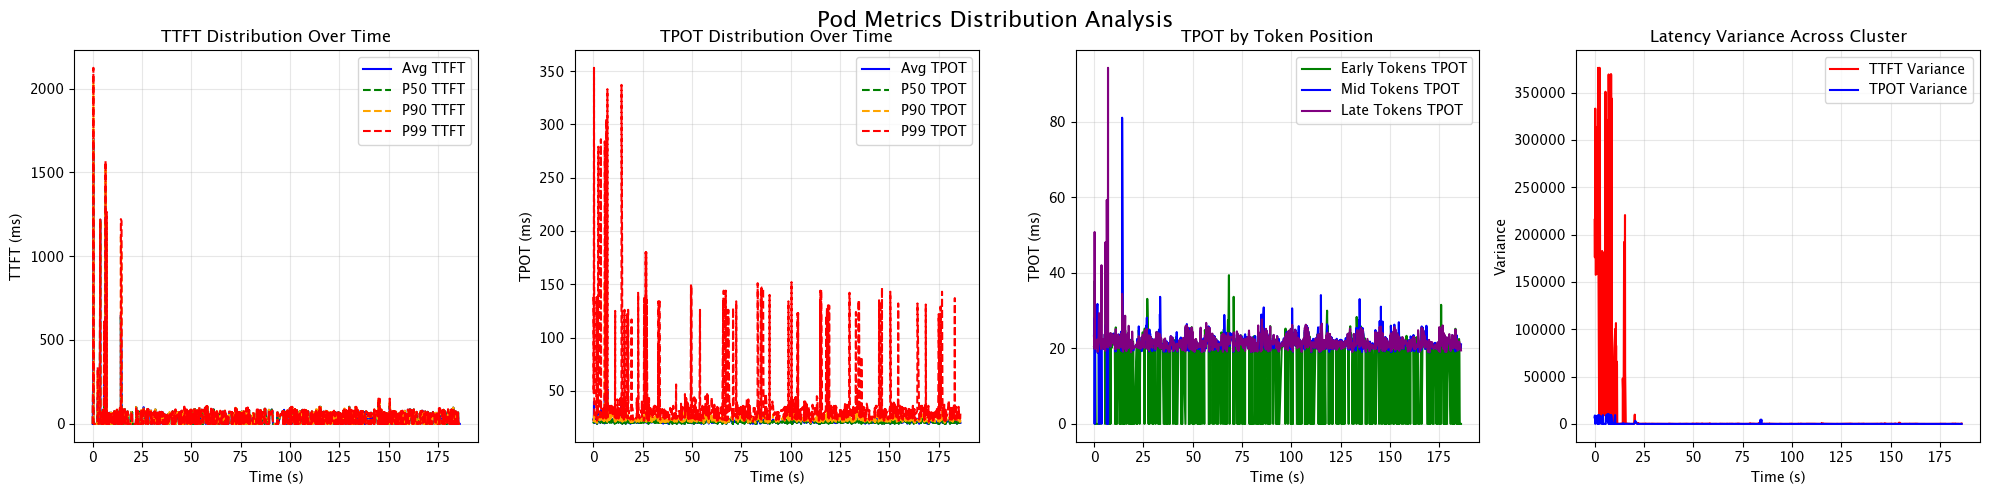

In [104]:
plot_utils.create_pod_metrics_distribution_plots(df)


In [24]:
# plot_utils.create_pod_metrics_histograms(df)

In [36]:
# df = df.fillna(0)

# # 1. Basic correlation analysis
# correlation_matrix, time_trends = analyze_latency_factors(df)

# # 2. Cluster analysis
# clusters, cluster_stats = create_latency_distribution_cluster_analysis(df)

# # 3. Anomaly detection
# anomalies = create_anomaly_detection(df)

# # 4. Decision tree analysis for thresholds
# create_latency_factor_decision_tree(df)

# print("\nAnalysis complete!")